Meeting https://chalmers.zoom.us/j/62371840613 <br>
Pw: 373416

In [1]:
import numpy as np
import numpy.random as rd

import pandas as pd
from seaborn import pairplot

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import ot

# Pre-processing & Visualization

In [2]:
data=pd.read_csv("kaggle_data/Admission_Predict.csv")
data["Gender"]=rd.choice([0,1],p=[0.75,.25],size=data.shape[0])
data["Admitted"]=np.where(data["Chance of Admit"]>0.69,1,0)
data.drop(["Serial No.","Chance of Admit","SOP", "LOR", "Research"],inplace=True, axis=1)

In [3]:
def sampling(data,n):
    inds=data.index
    return data.take(np.sort(rd.choice(inds,n, False)))

def split_attr_label(data):
    dat=data.copy()
    return dat.drop(["Admitted","Gender"],axis=1), dat.pop("Admitted"), dat.pop("Gender")

def normalize(x):
    return (x-x.mean())/x.std()

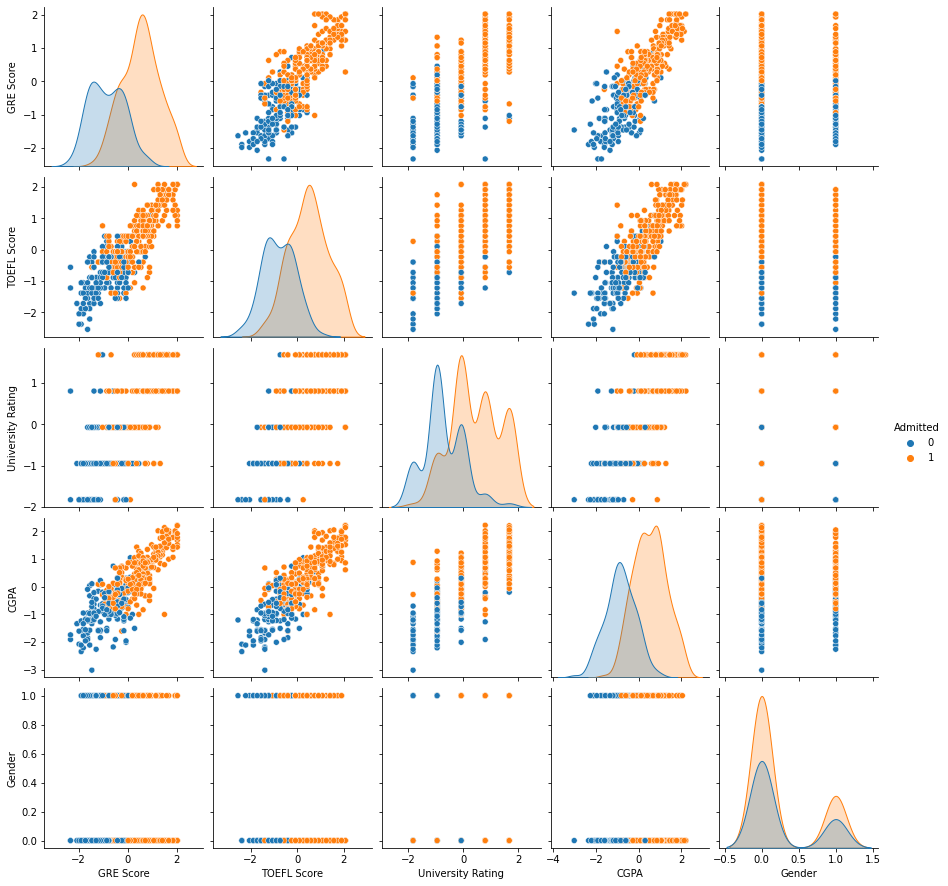

In [4]:
norm_data=normalize(data.iloc[:,:4])
norm_data["Gender"]=data["Gender"]
norm_data["Admitted"]=data["Admitted"]
pairplot(norm_data,hue="Admitted")

# True distribution

In [5]:
def distr(data,gen=1,adm=1):
    return data[(data["Gender"]==gen) & (data["Admitted"]==adm)].shape[0]/data.shape[0]

def compute_empirical_distribution(data):
    P=np.zeros((2,2))
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            P[i,j]=distr(data,i,j)
    return P

P=compute_empirical_distribution(data)
print(P)

[[0.2875 0.46  ]
 [0.095  0.1575]]


# R_opp

In [6]:
from numpy.linalg import norm
from scipy.optimize import fminbound
from scipy.optimize import fmin
from scipy.optimize import minimize
from scipy.optimize import Bounds

def term(k_i, x_i, lambda_i, gamma, beta):
    term1=(gamma*lambda_i*norm(beta)*k_i)**2
    term2=gamma*lambda_i/(1+np.exp(gamma*lambda_i*norm(beta)**2*k_i-beta@x_i))
    return term1+term2

# def find_min(x_i, lambda_i, gamma, beta):
#     minimum = fminbound(term, 0, 1/8, args=(x_i, lambda_i, gamma, beta), full_output=True)
#     return np.round(np.float(minimum[0]),4),np.round(np.float(minimum[1]),4)

def find_min(x_i, lambda_i, gamma, beta):
    minimum = minimize(term, [1/8], bounds=Bounds(0,1/8), args=(x_i, lambda_i, gamma, beta))
    return minimum.x[0],minimum.fun[0]

def sumI1(gamma,I1,beta):
    summ=0
    for ind,row in I1.iterrows():
        a_i=int(row["Gender"])
        y_i=int(row["Admitted"])
        x_i=np.array(row.iloc[:4])
        lambda_i=1/P[a_i,y_i] 
#         kopt,fopt=find_min(x_i,lambda_i,gamma,beta)
        fopt=term(0,x_i,lambda_i,gamma,beta)
        summ+=fopt
    return -np.round(summ,4)


def get_kopts(gamma_opt,I1,beta):
    Kopts=[]
    for ind,row in I1.iterrows():
        a_i=int(row["Gender"])
        y_i=int(row["Admitted"])
        x_i=np.array(row.iloc[:4])
        lambda_i=1/P[a_i,y_i] 
        Kopts.append(find_min(x_i,lambda_i,gamma_opt,beta)[0])
    return Kopts

def R_opp(data, classifier):
    beta=classifier.coef_[0]
    I1=data[data["Admitted"]==1]
    minimum=fmin(sumI1, 0, args=(I1,beta),full_output=True,disp=True)
    return minimum[0][0], -minimum[1]/len(data.index)

In [7]:
x,y,a=split_attr_label(data)
h=LogisticRegression().fit(x,y)

P=compute_empirical_distribution(norm_data)
gamma_opt, sup= R_opp(data, h)

[0.12245218 0.07123208 0.49774124 1.76625026]
0 10.526315789473685
(0.0, 10.526315789473685)


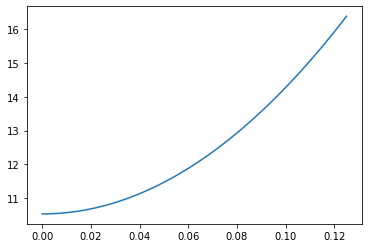

In [17]:
*x_i, gi, ai=data[data["Admitted"]==1].iloc[5]
lambda_i=1/P[int(ai),int(gi)]
beta=h.coef_[0]

print(beta)
vals=[]
for k_i in np.linspace(0,1/8,101):
    vals.append(term(k_i, x_i, lambda_i, 1, beta))
plt.plot(np.linspace(0,1/8,101),vals)

print(np.argmin(vals), np.min(vals))
print(find_min(x_i,lambda_i,1,beta))

In [9]:
x = np.linspace(0,1/8,100)
y = np.linspace(-1000,1000,1000)
X,Y = np.meshgrid(x, y) # grid of point
Z = term(X, x_i, lambda_i, Y, beta)


print(term(-1000, x_i, lambda_i, 0, beta))
print(term(0, x_i, lambda_i, 0, beta))
print(term(1000, x_i, lambda_i, 0, beta))

0.0
0.0
0.0


<ipython-input-6-5d73e4c93bf7>:9: RuntimeWarning: overflow encountered in exp
  term2=gamma*lambda_i/(1+np.exp(gamma*lambda_i*norm(beta)**2*k_i-beta@x_i))


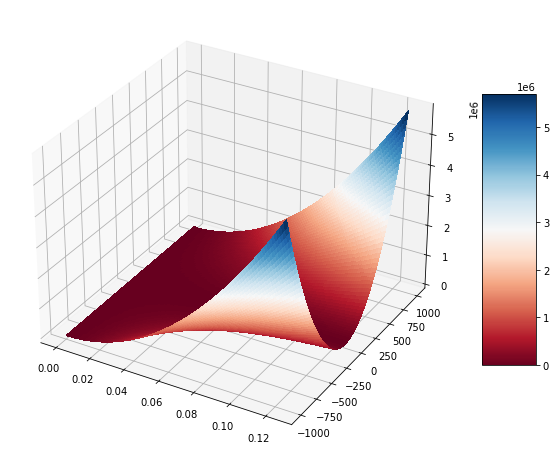

In [10]:
from matplotlib import cm


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.RdBu, cstride=1,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

6.338253001141125e+26


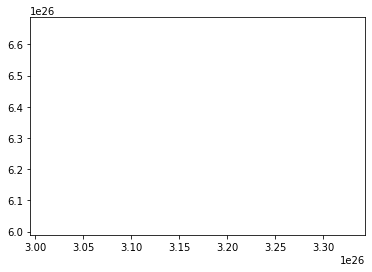

In [11]:
I1=data[data["Admitted"]==1]
vals=[]
for gamma in np.linspace(np.round(gamma_opt)-50,np.round(gamma_opt)+50,101):
    vals.append(-sumI1(gamma, I1, beta)/len(data.index))
plt.plot(np.linspace(np.round(gamma_opt)-50,np.round(gamma_opt)+50,101),vals)
print(vals[0])

# Q*

In [12]:
print(gamma_opt)
print(get_kopts(gamma_opt, data[data["Admitted"]==1], np.ones(4)))

3.169126500570575e+26


<ipython-input-6-5d73e4c93bf7>:9: RuntimeWarning: overflow encountered in exp
  term2=gamma*lambda_i/(1+np.exp(gamma*lambda_i*norm(beta)**2*k_i-beta@x_i))


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

# COMPAS

In [14]:
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

In [15]:
protected_attribute_used = 1 # 1, 2

dataset_orig = CompasDataset()
if protected_attribute_used == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]
    
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.6], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [16]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups (Train) = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups (Validation) = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups (Test) = %f" % metric_orig_test.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups (Train) = -0.148835
Difference in mean outcomes between unprivileged and privileged groups (Validation) = -0.100210
Difference in mean outcomes between unprivileged and privileged groups (Test) = -0.091571
